In [1]:
import numpy as np
import cv2
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
import yaml

In [3]:
parent_path = "drive/MyDrive/M202A/"

Hyperparameter Setup and other banal things

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Importing Data into Disk

In [5]:
path_to_dataset = parent_path+"transcg/"

config={"path":path_to_dataset,"all_files":[]}
def extract_files(config):
  path = config["path"]
  all_files = config["all_files"]
  for (path,directory,files) in tqdm(os.walk(path)):
    if(files!=[]):
      files= [path+"//"+i for i in files]
      if((path+"//rgb2.png" in files) and(path+"//depth2-gt.png" in files) and (path+"//depth2-gt-mask.png") and (path+"//depth2.png" in files)):
          all_files.append(files)


extract_files(config)

1921it [02:09, 14.86it/s]


In [34]:


def load_files(config):
  filepaths = config["all_files"]
  length = len(filepaths)
  batchsize = length//6
  indices = np.random.randint(low=0,high=length,size=batchsize)
  color = np.zeros((batchsize,1280,720,3)).astype(np.uint8)
  rawdepth = np.zeros((batchsize,1280,720)).astype(np.float32)
  groundtruth = np.zeros_like(rawdepth).astype(np.float32)
  depthmasks = np.zeros_like(rawdepth).astype(np.uint8)
  pbar = tqdm(total=batchsize)
  count = 0
  for idx in indices:
    files = filepaths[idx]
    for f in files:
      if("rgb2.png" in f):
        color[count,...] = np.asarray(Image.open(f)).transpose(1,0,2)
      elif("depth2-gt-mask.png" in f):
        depthmasks[count,...] = np.asarray(Image.open(f)).astype(np.uint8).T
      elif("depth2-gt.png" in f):
        groundtruth[count,...] = np.asarray(Image.open(f)).astype(np.float32).T
      elif("depth2.png" in f):
        rawdepth[count,...] = np.asarray(Image.open(f)).astype(np.float32).T
    pbar.update(1)
    count+=1
  config["color"] = color
  config["depth"] = groundtruth
  config["rawDepth"] = rawdepth
  config["validmasks"]= depthmasks

load_files(config)


100%|██████████| 318/318 [08:07<00:00,  1.53s/it]


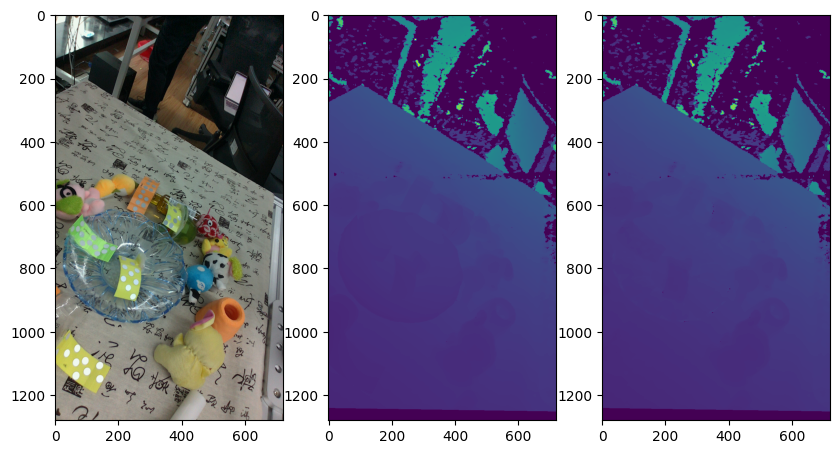

In [35]:
%matplotlib inline
fig,axs = plt.subplots(1,3,figsize=(10,10))
color = config["color"]
axs[0].imshow(color[0].astype(np.uint8))

depth = config["depth"]
axs[1].imshow(depth[0])
rawdepth = config["rawDepth"]
axs[2].imshow(rawdepth[0])



Loading Testing Dataset

In [37]:
rgb_config = {"R_u":-0.00776206,"R_w":0.01519309,"Rvar":6.88208756e-06,
              "G_u":0.01147944,"G_w":0.50978071,"Gvar":9.19419688e-06,
              "B_u":0.00371937,"B_w":0.47502621,"Bvar":6.89479643e-06}

# Depth Noise based on the Channels, readings taken @0.5m

Loading Pretrained Unet for Depth

In [38]:
with open(parent_path+'config.yaml', 'r') as file:
    model_configs = yaml.safe_load(file)
model_configs['model']['channels']=1
model_configs['model']['base filters']=16

In [39]:
from model import *

Creating New Network by mixing the two

In [40]:
class Resnet_UNet(nn.Module):
  """
  Residual-Dense U-net for image denoising.
  """
  def __init__(self,**kwargs):
      super().__init__()
      channels = kwargs['channels']
      filters_0 = kwargs['base filters']
      filters_1 = 2 * filters_0
      filters_2 = 4 * filters_0
      filters_3 = 8 * filters_0

      # Encoder:
      # Level 0:
      self.drop = nn.Dropout(p=0.5)
      self.input_block = InputBlock(4, filters_0)
      self.block_0_0 = DenoisingBlock(filters_0, filters_0 // 2, filters_0)
      self.block_0_1 = DenoisingBlock(filters_0, filters_0 // 2, filters_0)
      self.down_0 = DownsampleBlock(filters_0, filters_1)

      # Level 1:
      self.block_1_0 = DenoisingBlock(filters_1, filters_1 // 2, filters_1)
      self.block_1_1 = DenoisingBlock(filters_1, filters_1 // 2, filters_1)
      self.down_1 = DownsampleBlock(filters_1, filters_2)

      # Level 2:
      self.block_2_0 = DenoisingBlock(filters_2, filters_2 // 2, filters_2)
      self.block_2_1 = DenoisingBlock(filters_2, filters_2 // 2, filters_2)
      self.down_2 = DownsampleBlock(filters_2, filters_3)

      # Level 3 (Bottleneck)
      self.block_3_0 = DenoisingBlock(filters_3, filters_3 // 2, filters_3)
      self.block_3_1 = DenoisingBlock(filters_3, filters_3 // 2, filters_3)

      # Decoder
      # Level 2:
      self.up_2 = UpsampleBlock(filters_3, filters_2, filters_2)
      self.block_2_2 = DenoisingBlock(filters_2, filters_2 // 2, filters_2)
      self.block_2_3 = DenoisingBlock(filters_2, filters_2 // 2, filters_2)

      # Level 1:
      self.up_1 = UpsampleBlock(filters_2, filters_1, filters_1)
      self.block_1_2 = DenoisingBlock(filters_1, filters_1 // 2, filters_1)
      self.block_1_3 = DenoisingBlock(filters_1, filters_1 // 2, filters_1)

      # Level 0:
      self.up_0 = UpsampleBlock(filters_1, filters_0, filters_0)
      self.block_0_2 = DenoisingBlock(filters_0, filters_0 // 2, filters_0)
      self.block_0_3 = DenoisingBlock(filters_0, filters_0 // 2, filters_0)

      self.output_block = OutputBlock(filters_0, channels)


  def forward(self, inputs):
      inputs = self.drop(inputs)
      out_0 = self.input_block(inputs)    # Level 0
      out_0 = self.block_0_0(out_0)
      out_0 = self.block_0_1(out_0)

      out_1 = self.down_0(out_0)          # Level 1
      out_1 = self.block_1_0(out_1)
      out_1 = self.block_1_1(out_1)

      out_2 = self.down_1(out_1)          # Level 2
      out_2 = self.block_2_0(out_2)
      out_2 = self.block_2_1(out_2)

      out_3 = self.down_2(out_2)          # Level 3 (Bottleneck)

      out_3 = self.block_3_0(out_3)
      out_3 = self.block_3_1(out_3)



      out_4 = self.up_2([out_3, out_2])   # Level 2
      out_4 = self.block_2_2(out_4)
      out_4 = self.block_2_3(out_4)

      out_5 = self.up_1([out_4, out_1])   # Level 1
      out_5 = self.block_1_2(out_5)
      out_5 = self.block_1_3(out_5)

      out_6 = self.up_0([out_5, out_0])   # Level 0
      out_6 = self.block_0_2(out_6)
      out_6 = self.block_0_3(out_6)

      return self.output_block(out_6)


In [41]:
ResUnet = Resnet_UNet(**model_configs['model'])
ResUnet.load_state_dict(torch.load("drive/MyDrive/M202A/MSE_Model.pth"))
ResUnet.to(device)


Resnet_UNet(
  (drop): Dropout(p=0.5, inplace=False)
  (input_block): InputBlock(
    (conv_1): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (actv_1): PReLU(num_parameters=16)
    (actv_2): PReLU(num_parameters=16)
  )
  (block_0_0): DenoisingBlock(
    (conv_0): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_1): Conv2d(24, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_2): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_3): Conv2d(40, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (actv_0): PReLU(num_parameters=8)
    (actv_1): PReLU(num_parameters=8)
    (actv_2): PReLU(num_parameters=8)
    (actv_3): PReLU(num_parameters=16)
  )
  (block_0_1): DenoisingBlock(
    (conv_0): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_1): Conv2d(24, 8, kernel_size=(3, 3), stride=(1, 1),

Loading Optimizers, Schedulers and Training the network

In [42]:
from tqdm import tqdm
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

In [ ]:
from torchvision.transforms import v2
transforms = v2.Compose([v2.CenterCrop((480,640))])

```
Sanity Testing the Segmentaion Loss before plugging it into the loss model
```

In [82]:

error = []
color=config["color"]
truedepth = config["depth"]
rawdepth= config["rawDepth"]
length = len(color)
pbar = tqdm(total=length)
with torch.no_grad():
  for i in range(0,len(depth)):
    depth_img = torch.tensor(rawdepth[i],dtype=torch.float32).to(device)
    depth_img = transforms(depth_img).reshape(1,1,480,640)*2.5e-4
    color_img  = torch.tensor(color[i],dtype=torch.float32).to(device).permute(2,0,1).unsqueeze(0)/255
    color_img = transforms(color_img)
    stacked = torch.hstack((depth_img,color_img))
    noise_estimate = ResUnet(stacked)

    denoised_depth = (stacked[:,0,:,:].unsqueeze(1) - noise_estimate)

    mask =depth_img> 0
    masked_denoised_depth =denoised_depth*mask
    gt = truedepth[i]
    gt_tensor = transforms(torch.tensor(gt,dtype=torch.float).to(device))*2.5e-4
    loss = (masked_denoised_depth-gt_tensor*mask).to("cpu").detach().numpy()
    error.append(loss)
    pbar.update(1)
  mae = [np.mean(abs(i)) for i in error]
  rmse = [np.sqrt(np.mean(i**2)) for i in error]
  print("Average mean squared error is ",np.mean(mae)*1000,"mm")
  print("Average root mean squared error is ",np.mean(rmse)*1000,"mm")


100%|██████████| 318/318 [00:20<00:00, 15.53it/s]

Average mean squared error is  35.99782660603523 mm
Average root mean squared error is  46.282462775707245 mm


Finetuning

In [ ]:
indices =